# Image search with autoencoders

Autoencoders are an architecture that have a variety of applications from [denoising data](http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf) to [generative models](https://arxiv.org/1312.6114.pdf).

In this post we will look at how to search for images using autoencoders. The two papers that guide this post are [Semantic Hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf) and [Using Very Deep Autoencoders for Content-Based Image Retrieval](http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf).

# Autoencoders, the gist

The autoencoders considered in this post are simply neural networks that learn the mapping $f:X\mapsto X$. Sounds too easy doesn't it? And why would we want to learn to predict the data we already have?

The key idea behind the architecture of an autoencoder is that a "bottleneck" is placed in the middle of the network. This implicitly forces the network to learn a compressed representation of the input data, which is what we are actually interested in.

More specifically we actually think of the autoencoder as two pieces, the _encoder_ which is the first half of the network mapping $X\in \mathbb{R}^{n}$ to some vector in $\mathbb{R}^{d}$ and the _decoder_ which maps that vector back to $\mathbb{R}^{n}$. The vector output by the encoder is called the _latent representation_ of the data which is what we will use in our image search. Again, at the end of the day all we really care about is the output of the bottleneck.

This picture below should clear up any ambiguity

<img src="./static/autoencoder-architecture.png">

One really nice thing about autoencoders is that the idea described above is very intuitive. Suppose our data $X$ lives in $\mathbb{R}^{n}$ and one of the hidden layers of $f$ outputs a vector of dimmension $d<n$. Then, intuitively it makes sense that if $f$ reconstructs $X$ well after reducing the input in dimmensionality then the output of that hidden layer must contain a lot of information about $X$ in order to reproduce $X$.

# Autoencoders for searching

So how do we apply autoencoders to searching?

Let's consider the use case where we have a set of images $X$, and for a given image $q$ we would like to retrieve all images in $X$ that are "similar" to $q$.

One such way to do this with an autoencoder is to keep a list of key-value pairs of each image $x\in X$ and its encoded representation $\hat{x}$. Recall these codes are simply vectors, so we can compute similarity scores of $\hat{q}$ and each $\hat{x}$, returning the images which scored highest. This is already more efficient than simply computing the similarity scores on the raw values in $X$ in the sense that the encoded representations are much smaller in dimmension. However, both methods are linear searches with time complexity $O(|X|)$, that is the more images we have in our database, the longer the search will take and the less benefit we see in performance from computing the similarity scores on smaller vectors.

It turns out we can still use the codes to perform a faster search in constant time, we just need to add one extra step. We now define the encoder as $\phi:\mathbb{R}^{n}\mapsto\{0,1\}^{d}$ ($d$-bit binary codes). Once again we keep a list of key-value pairs, but this time the key is a $d$-bit integer rather than a real valued vector of dimmension $d$. Then for our query image $q$ we now return all images $x\in X$ such that the hamming distince (number of bits that differ) of $\phi(q)$ and $\phi(x)$ is less than some predetermined threshold $t$.

# A few remarks on building and training the autoencoder

## Learning binary codes

You may be asking how does one constrain the neural network to learn binary codes. It turns out this is actually rather simple. Several techniques, such as adding gaussian noise to the mini-batches, for doing this are discussed in [Semantic Hashing](http://www.cs.utoronto.ca/~rsalakhu/papers/semantic_final.pdf) however the simplest method, described in [here](http://www.cs.toronto.edu/~fritz/absps/esann-deep-final.pdf), is to feed the outputs of the hidden layer which outputs the latent vector into a softmax, round those values up to 1 or down to 0 and then compute the gradient update as if the rounding never occurred.

We can do this in keras with a custom layer using `keras.backend.round()` and `keras.backend.stop_gradient()` as follows.

```python
import keras
from keras.layers import Lambda
def binarize(x):
    return x + K.stop_gradient(K.round(x) - x)
Binarize = Lambda(binarize, output_shape=lambda x: x, name='encoding')
```

## Overfitting on the data

Depending on the use case it may be perfectly acceptable to train on the same data we intend to search over.

## Choosing the latent dimmension and threshold

Let's consider the MNIST digits data set as an example of working out a heuristic for choosing the latent dimmension and threshold since that's what we'll be working with below. In the train split provided by keras there are $60,000$ images. If the number of possible binary codes output by the autoencoder is $2^d=N$, then we will have approximately $60,000/N$ images stored per code (assuming the images are distributed uniformly across the codes). In the papers referenced in the beginning of this post the author's found good results when there were about 0.4 items per code so we'll choose $d=17$ which gives us a total of $N=131072$ codes and approximately $0.46$ images per code.

Now, lets choose our threshold as $t=3$, then we have

/Users/dgates/venvs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


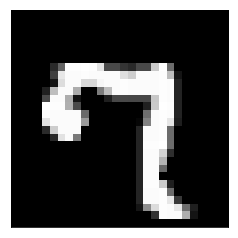

In [1]:
from utils import *
X_train, _ = fetch_data()
X_train.shape

# Training an autoencoder

In [3]:
from autoencoding import AutoEncoder
INPUT_DIM = X_train.shape[-1]
LATENT_DIM = 17
INTERMEDIATE_DIMS = [1000, 700, 300,  150, 75]
OUTPUT_ACTIVATION = 'sigmoid'
EPOCHS = 125
BATCH_SIZE = 256

In [4]:
autoencoder = AutoEncoder(
    INPUT_DIM,
    LATENT_DIM,
    INTERMEDIATE_DIMS,
    OUTPUT_ACTIVATION)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 700)               700700    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               210300    
_________________________________________________________________
dense_4 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_5 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_6 (Dense)              (None, 17)                1292      
__________

In [5]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

In [6]:
autoencoder.fit(X_train, X_train,
                epochs=250,
                batch_size=256,
                shuffle=True)

Epoch 1/250
60000/60000 [==============================] - 42s 694us/step - loss: 0.3013
Epoch 2/250
60000/60000 [==============================] - 40s 660us/step - loss: 0.2532
Epoch 3/250
60000/60000 [==============================] - 39s 649us/step - loss: 0.2506
Epoch 4/250
60000/60000 [==============================] - 36s 592us/step - loss: 0.2461
Epoch 5/250
60000/60000 [==============================] - 35s 589us/step - loss: 0.2423
Epoch 6/250
60000/60000 [==============================] - 38s 640us/step - loss: 0.2388
Epoch 7/250
60000/60000 [==============================] - 35s 582us/step - loss: 0.2357
Epoch 8/250
60000/60000 [==============================] - 35s 583us/step - loss: 0.2310
Epoch 9/250
60000/60000 [==============================] - 35s 576us/step - loss: 0.2256
Epoch 10/250
60000/60000 [==============================] - 38s 636us/step - loss: 0.2209
Epoch 11/250
60000/60000 [==============================] - 41s 678us/step - loss: 0.2162
Epoch 12/250
60000/

60000/60000 [==============================] - 35s 578us/step - loss: 0.1550
Epoch 93/250
60000/60000 [==============================] - 35s 575us/step - loss: 0.1549
Epoch 94/250
60000/60000 [==============================] - 35s 581us/step - loss: 0.1546
Epoch 95/250
60000/60000 [==============================] - 35s 577us/step - loss: 0.1545
Epoch 96/250
60000/60000 [==============================] - 35s 579us/step - loss: 0.1544
Epoch 97/250
60000/60000 [==============================] - 35s 576us/step - loss: 0.1545
Epoch 98/250
60000/60000 [==============================] - 35s 580us/step - loss: 0.1543
Epoch 99/250
60000/60000 [==============================] - 35s 576us/step - loss: 0.1540
Epoch 100/250
60000/60000 [==============================] - 35s 578us/step - loss: 0.1541
Epoch 101/250
60000/60000 [==============================] - 35s 578us/step - loss: 0.1538
Epoch 102/250
60000/60000 [==============================] - 35s 576us/step - loss: 0.1538
Epoch 103/250
60000/

KeyboardInterrupt: 

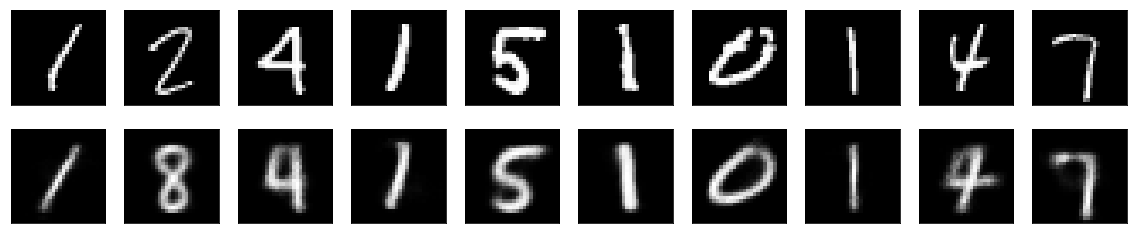

In [7]:
test_sample = choices(X_test, k=10)
reconstructions = autoencoder.predict(test_sample)
show_side_by_side(test_sample, reconstructions)

In [156]:
encoder = autoencoder.bit_encoder

# Linear search over test images

In [157]:
def cosine_sim(v1, v2):
    return v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [158]:
# define key-value pairs of encoding, image for search
kvps = [(code, image) for code, image in zip(encoder.predict(X_train), X_train)]

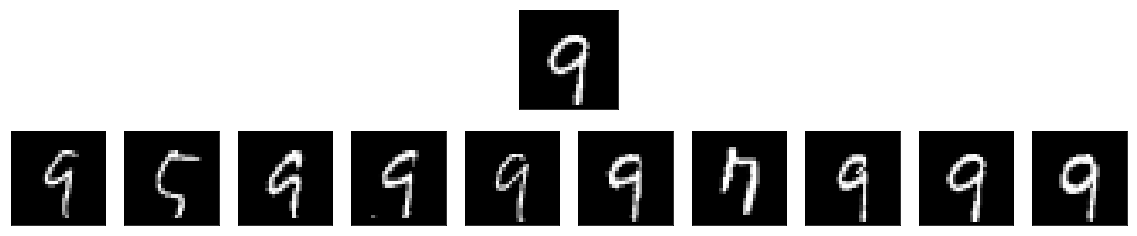

CPU times: user 1.64 s, sys: 35.3 ms, total: 1.67 s
Wall time: 1.72 s


In [162]:
%%time
import random
# pick on image from test set
query_img = random.choice(X_train).reshape(1, 784)

# retrieve similar images
query_code = encoder.predict(query_img)
sims = [(cosine_sim(query_code, stored_code), image) for stored_code, image in kvps]
# get top 10 images
sorted_sims = sorted(sims, reverse=True, key=lambda x: x[0])
top_matches = [img for _, img in sorted_sims[:10]]

show_side_by_side(query_img, top_matches)

In [160]:
# the codes are binary aren't they?
query_code

array([[0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1.]], dtype=float32)

# Semantic hashing

In [95]:
encoder = autoencoder.integer_encoder

In [138]:
import collections
import statistics

# see,
# https://en.wikipedia.org/wiki/Hamming_distance#Algorithm_example
def hamming_distance(n1, n2):
    # this number is made of each bit in either n1 or n2
    # but not both
    v = n1 ^ n2
    d = 0
    while v != 0:
        # subtracting 1 clears the least bit, a, in v and sets all bits
        # before a which are cleared by the logical &
        # 2^n = sum(2^m for 0 <= m <= n-1)
        d += 1
        v &= v - 1
    return d


class DB:
    def __init__(self, encoder, items=None):
        self.encoder = encoder
        output_dim = self.encoder.output_shape[-1]
        self._init_db(items)

    def search(self, item, threshold=3, top_n=10):
        key = self._make_keys(item)[0]
        hits = self._find_hits(key, threshold)
        items = self._fetch_items(hits, top_n)
        return items

    def _find_hits(self, key, threshold):
        hits = collections.defaultdict(int)
        for other_key in self._db:
            dist = hamming_distance(other_key, key)
            if dist <= threshold:
                hits[other_key] += 2**(threshold-dist)
        return hits

    def _fetch_items(self, hits, top_n):
        items = []
        sorted_hits = sorted(hits.items(), key=lambda x: x[1])
        for key, score in sorted_hits:
            # items from the same bucket are added arbitrarily
            for item in self._db[key]:
                items.append(item)
                if len(items) > top_n:
                    return items
        return items

    def _init_db(self, items):
        self._db = collections.defaultdict(list)
        keys = self._make_keys(items)
        for key, item in zip(keys, items):
            self._db[key].append(item)
        # defaultdict is convenient when initializing the DB instance
        # but dangerous to keep around.
        self._db.default_factory = None

    def _make_keys(self, items):
        codes = self.encoder.predict(items).flatten()
        return codes.astype(np.uint32)
    
    def describe(self):
        bucket_sizes = [len(v) for v in self._db.values()]
        median_density = statistics.median(bucket_sizes)
        mean_density = statistics.mean(bucket_sizes)
        min_density = min(bucket_sizes)
        max_density = max(bucket_sizes)
        print('median density:', median_density)
        print('mean density:', mean_density)
        print('min density:', min_density)
        print('max density:', max_density)

In [139]:
%%time
db = DB(encoder, X_train)

CPU times: user 19 s, sys: 492 ms, total: 19.5 s
Wall time: 6.51 s


In [140]:
db.describe()

median density: 3.0
mean density: 7.177033492822966
min density: 1
max density: 234


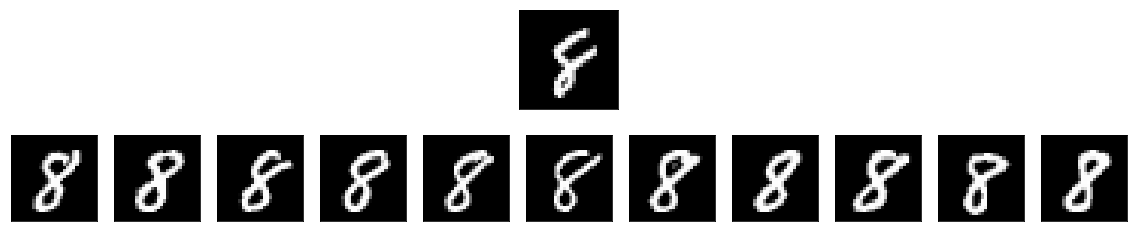

CPU times: user 588 ms, sys: 8.1 ms, total: 596 ms
Wall time: 595 ms


In [154]:
%%time
query_img = random.choice(X_train).reshape(1, -1)
res = db.search(query_img, threshold=2)
show_side_by_side(query_img, res)